# SPArrOW quickstart

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sparrow as sp

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


## 1. Read in the data

The first step includes reading in the raw data.

The example dataset for this notebook will be downloaded and cached using `pooch` via `sparrow.dataset.registry`.


### Convert to zarr and read the image


In [3]:
import os
import tempfile
import uuid

from sparrow.datasets.registry import get_registry

# change this path. It is the directory where the spatialdata .zarr will be saved.
OUTPUT_DIR = tempfile.gettempdir()

img_layer = "raw_image"

path = None  # If None, example data will be downloaded in the default cache folder of your os. Set this to a custom path, to change this behaviour.
registry = get_registry(path=path)
path_image = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_DAPI.tiff")

# you can choose any name for your zarr file
zarr_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata = sp.io.create_sdata(
    input=path_image,
    output_path=zarr_path,
    img_layer=img_layer,
    chunks=1024,
)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_23a7e45d-4d49-4ff7-a2d7-cf88ae76dfb4.zarr          


/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
2024-10-14 11:27:59,510 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-10-14 11:27:59,515 - sparrow.image._manager - INFO - Writing results to layer 'raw_image'


## 2. Plot the image


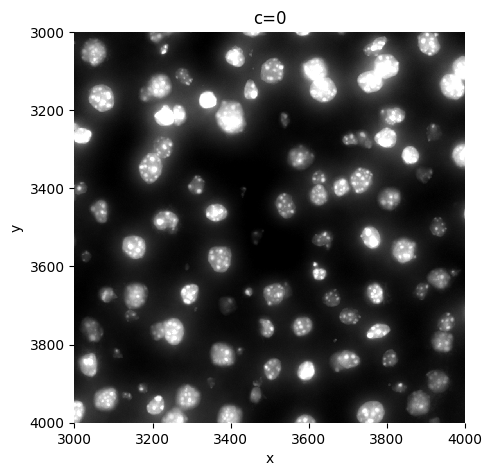

In [4]:
sp.pl.plot_image(
    sdata,
    img_layer="raw_image",
    crd=[3000, 4000, 3000, 4000],  # region to plot [x_min, xmax, y_min, y_max]
    figsize=(5, 5),
)

## 3. Segment using Cellpose


In [5]:
from sparrow.image.segmentation.segmentation_models._cellpose import _cellpose

sdata = sp.im.segment(
    sdata,
    img_layer="raw_image",
    chunks=2048,
    depth=200,
    model=_cellpose,  # can be any callable. GPU will be used for segmentation if it could be found by torch (torch.cuda.is_available())
    # parameters that will be passed to the callable _cellpose
    diameter=50,
    flow_threshold=0.9,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],  # region to segment [x_min, xmax, y_min, y_max],
    overwrite=True,
)

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
2024-10-14 11:01:57,175 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-10-14 11:01:57,178 - sparrow.image._manager - INFO - Writing results to layer 'segmentation_mask'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


## 4. Visualize resulting segmentation


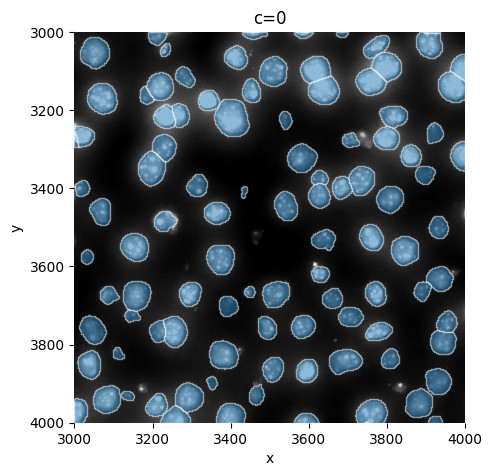

In [6]:
sp.pl.plot_shapes(
    sdata,
    img_layer="raw_image",
    shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],
    figsize=(5, 5),
)

## 5. Working with a Dask Client


In [4]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=1,
    threads_per_worker=10,
    memory_limit="32GB",
)

client = Client(cluster)

print(client.dashboard_link)

http://127.0.0.1:8787/status


In [5]:
from sparrow.image.segmentation.segmentation_models._cellpose import _cellpose

import torch
from cellpose import models

gpu = False
device = "cpu"
model = models.CellposeModel(gpu=gpu, pretrained_model="nuclei", device=torch.device(device))

model = client.scatter(model)  # pass a loaded model to _cellpose, but we scatter the model to avoid large task graph

sdata = sp.im.segment(
    sdata,
    img_layer="raw_image",
    chunks=2048,
    depth=200,
    model=_cellpose,  # can be any callable. GPU will be used for segmentation if it could be found by torch (torch.cuda.is_available())
    # parameters that will be passed to the callable _cellpose
    pretrained_model=model,
    diameter=50,
    flow_threshold=0.9,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],  # region to segment [x_min, xmax, y_min, y_max],
    overwrite=True,
)

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename

In [6]:
client.close()